In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import pandas as pd
from sklearn import model_selection
from scipy.signal import hilbert
import scipy
from PyEMD import EMD
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# windowing
wLen = 250 #ms
def window (e):
    return e.unfold(dimension=0, size=wLen, step=50)

# mat to tensor
def getData (subject, gesture, trial):
    sub = str(subject)
    if subject < 10:
        sub = '0' + str(subject)
    name = '0' + sub + '-00' + str(gesture) + '-00' +str(trial)
    if trial == 10:
        name = '0' + sub + '-00' + str(gesture) + '-010'
    mat_data = scipy.io.loadmat('./CapgMyo_B/dbb-preprocessed-0' + sub + '/' + name + '.mat')
    mat_array = mat_data['data']
    tensor_data = torch.from_numpy(mat_array)
    if trial < 10:
        return torch.cat((window(tensor_data), getData(subject, gesture, trial + 1)), dim=0)
    elif gesture < 8:
        return torch.cat((window(tensor_data), getData(subject, gesture + 1, 1)), dim=0)
    else:
        return window(tensor_data)
        
def makeLabels (emg):
    labels = torch.tensor(())
    labels = labels.new_zeros(size=(len(emg), 8))
    for x in range (8):
        for y in range (int(len(emg) / 8)):
            labels[int(x * (len(emg) / 8) + y)][x] = 1.0
    return labels

S1_emg = torch.cat((getData(1, 1, 1), getData(2, 1, 1)), dim=0)
S1_labels = makeLabels(S1_emg)
S2_emg = torch.cat((getData(3, 1, 1), getData(4, 1, 1)), dim=0)
S2_labels = makeLabels(S2_emg)
S3_emg = torch.cat((getData(5, 1, 1), getData(6, 1, 1)), dim=0)
S3_labels = makeLabels(S3_emg)
S4_emg = torch.cat((getData(7, 1, 1), getData(8, 1, 1)), dim=0)
S4_labels = makeLabels(S4_emg)
S5_emg = torch.cat((getData(9, 1, 1), getData(10, 1, 1)), dim=0)
S5_labels = makeLabels(S5_emg)
S6_emg = torch.cat((getData(11, 1, 1), getData(12, 1, 1)), dim=0)
S6_labels = makeLabels(S6_emg)
S7_emg = torch.cat((getData(13, 1, 1), getData(14, 1, 1)), dim=0)
S7_labels = makeLabels(S7_emg)
S8_emg = torch.cat((getData(15, 1, 1), getData(16, 1, 1)), dim=0)
S8_labels = makeLabels(S8_emg)
S9_emg = torch.cat((getData(17, 1, 1), getData(18, 1, 1)), dim=0)
S9_labels = makeLabels(S9_emg)
S10_emg = torch.cat((getData(19, 1, 1), getData(20, 1, 1)), dim=0)
S10_labels = makeLabels(S10_emg)

emg = [S1_emg, S2_emg, S3_emg, S4_emg, S5_emg, S6_emg, S7_emg, S8_emg, S9_emg, S10_emg]
labels = [S1_labels, S2_labels, S3_labels, S4_labels, S5_labels, S6_labels, S7_labels, S8_labels, S9_labels, S10_labels]
print(len(labels))

10


In [3]:
# find max channel for SAV of each subject for gestures 13, 14, 16, and 17 - using these channels to generate spectrograms
def getEMG_noWindow (subject, gesture, trial):
    sub = str(subject)
    if subject < 10:
        sub = '0' + str(subject)
    name = '0' + sub + '-00' + str(gesture) + '-00' +str(trial)
    if trial == 10:
        name = '0' + sub + '-00' + str(gesture) + '-010'
    mat_data = scipy.io.loadmat('./CapgMyo_B/dbb-preprocessed-0' + sub + '/' + name + '.mat')
    mat_array = mat_data['data']
    tensor_data = torch.from_numpy(mat_array)
    if trial < 10:
        return torch.cat((tensor_data, getEMG_noWindow(subject, gesture, trial + 1)), dim=0)
    else:
        return tensor_data

def findMaxChannel(subject):
    maxChannels = []
    for i in range (8):
        emg = torch.cat((getEMG_noWindow(subject, i+1, 1), getEMG_noWindow(subject+1, i+1, 1)), dim=0)
        channelSums = torch.sum(torch.abs(emg), dim=0)
        max = 0
        maxIndex = 0
        for c in range (len(channelSums)):
            if (c not in maxChannels and channelSums[c] > max):
                max = channelSums[c]
                maxIndex = c
        maxChannels += [maxIndex]
        if (i == 2):
            max = 0
            maxIndex = 0
            for c in range (len(channelSums)):
                if (c not in maxChannels and channelSums[c] > max):
                    max = channelSums[c]
                    maxIndex = c
            maxChannels += [maxIndex]
    return maxChannels

maxChannels = []
for i in range (1):
    maxChannels += [findMaxChannel(i+1)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 0/2560
tensor([1., 0., 0., 0., 0., 0., 0., 0.])


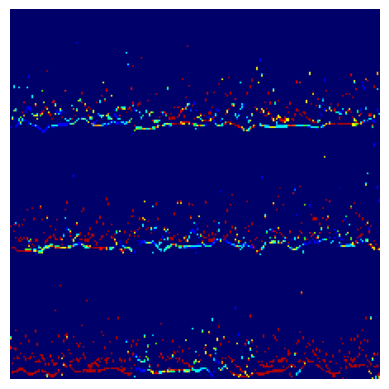

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 100/2560
tensor([1., 0., 0., 0., 0., 0., 0., 0.])


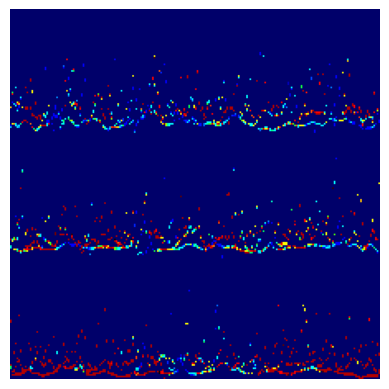

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 200/2560
tensor([1., 0., 0., 0., 0., 0., 0., 0.])


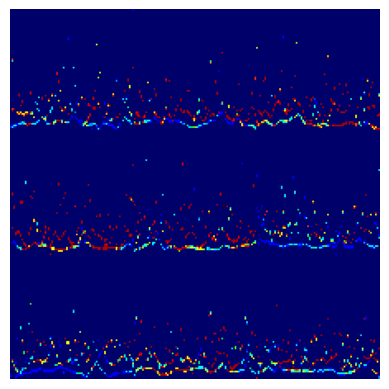

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 300/2560
tensor([1., 0., 0., 0., 0., 0., 0., 0.])


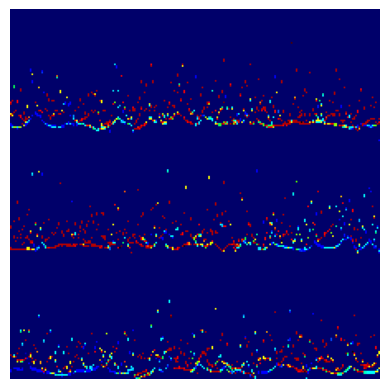

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 400/2560
tensor([0., 1., 0., 0., 0., 0., 0., 0.])


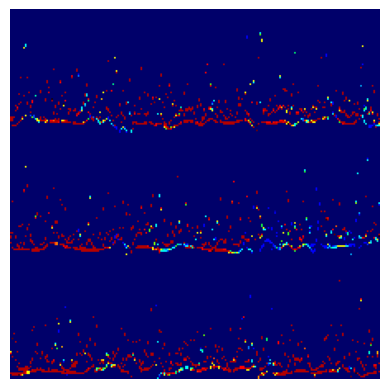

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 500/2560
tensor([0., 1., 0., 0., 0., 0., 0., 0.])


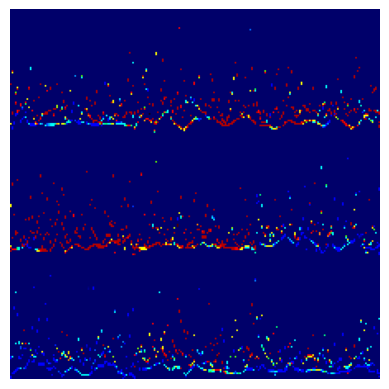

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 600/2560
tensor([0., 1., 0., 0., 0., 0., 0., 0.])


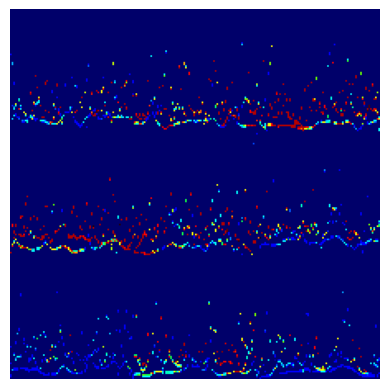

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 700/2560
tensor([0., 0., 1., 0., 0., 0., 0., 0.])


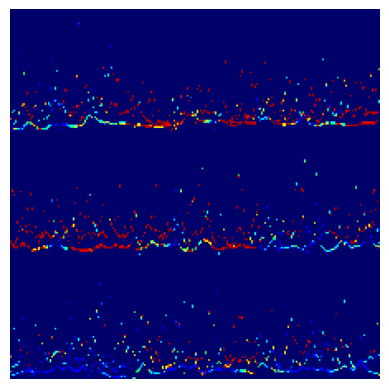

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 800/2560
tensor([0., 0., 1., 0., 0., 0., 0., 0.])


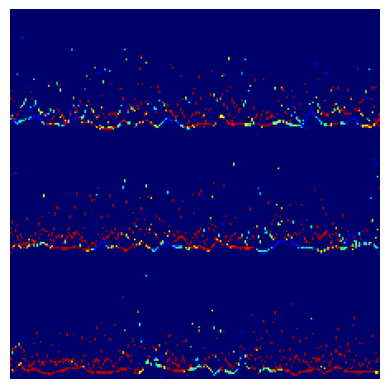

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 900/2560
tensor([0., 0., 1., 0., 0., 0., 0., 0.])


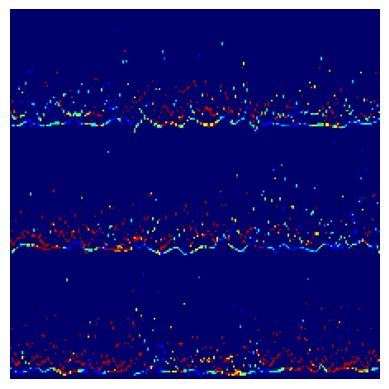

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1000/2560
tensor([0., 0., 0., 1., 0., 0., 0., 0.])


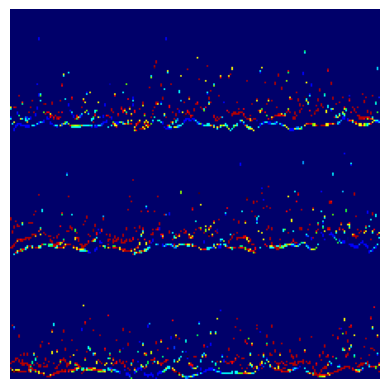

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1100/2560
tensor([0., 0., 0., 1., 0., 0., 0., 0.])


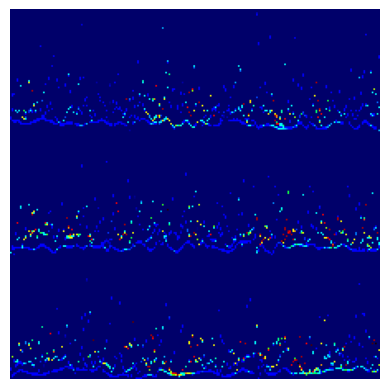

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1200/2560
tensor([0., 0., 0., 1., 0., 0., 0., 0.])


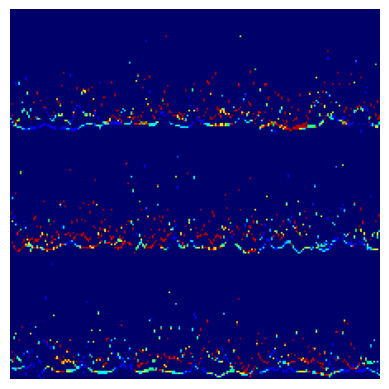

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1300/2560
tensor([0., 0., 0., 0., 1., 0., 0., 0.])


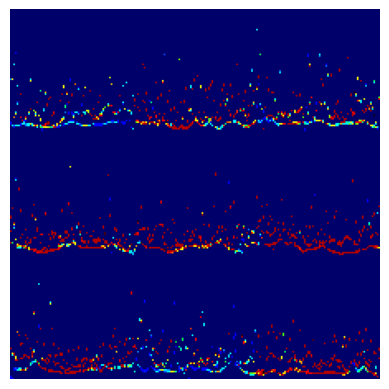

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1400/2560
tensor([0., 0., 0., 0., 1., 0., 0., 0.])


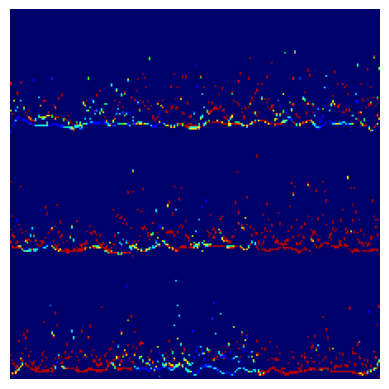

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1500/2560
tensor([0., 0., 0., 0., 1., 0., 0., 0.])


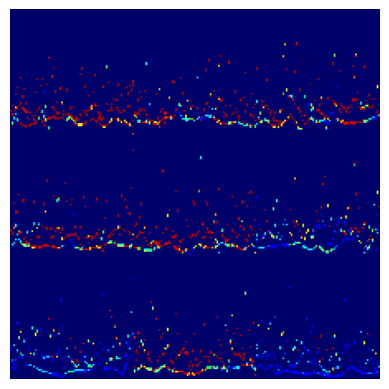

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1600/2560
tensor([0., 0., 0., 0., 0., 1., 0., 0.])


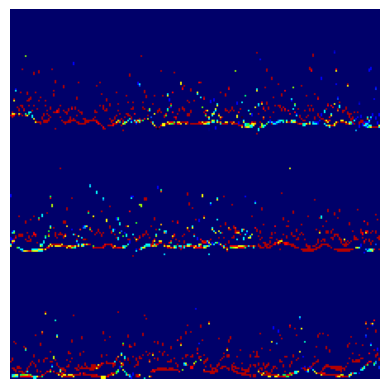

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1700/2560
tensor([0., 0., 0., 0., 0., 1., 0., 0.])


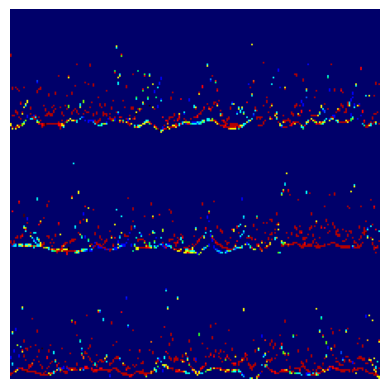

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1800/2560
tensor([0., 0., 0., 0., 0., 1., 0., 0.])


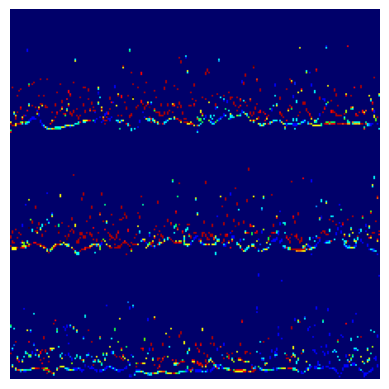

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 1900/2560
tensor([0., 0., 0., 0., 0., 1., 0., 0.])


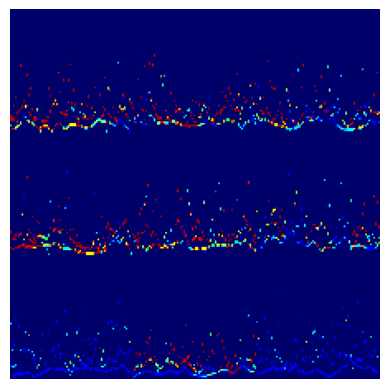

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 2000/2560
tensor([0., 0., 0., 0., 0., 0., 1., 0.])


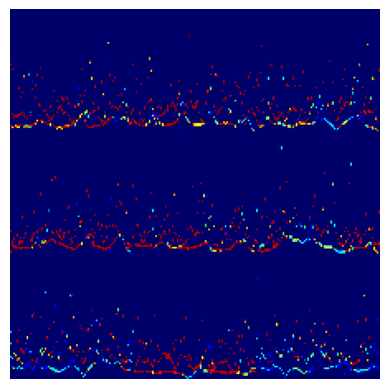

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 2100/2560
tensor([0., 0., 0., 0., 0., 0., 1., 0.])


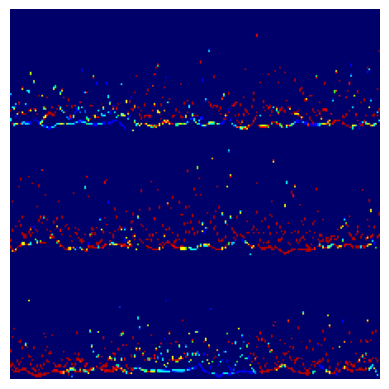

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 2200/2560
tensor([0., 0., 0., 0., 0., 0., 1., 0.])


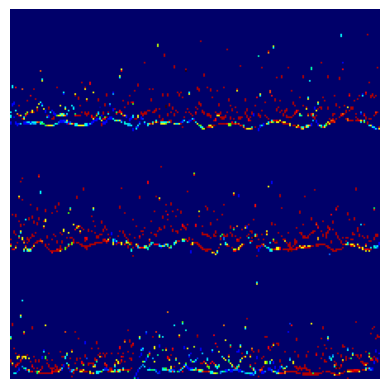

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 2300/2560
tensor([0., 0., 0., 0., 0., 0., 0., 1.])


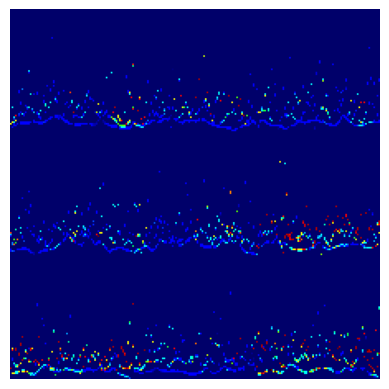

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 2400/2560
tensor([0., 0., 0., 0., 0., 0., 0., 1.])


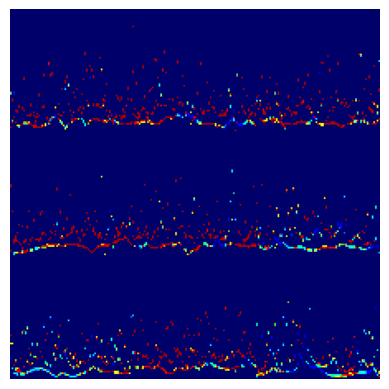

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress: 2500/2560
tensor([0., 0., 0., 0., 0., 0., 0., 1.])


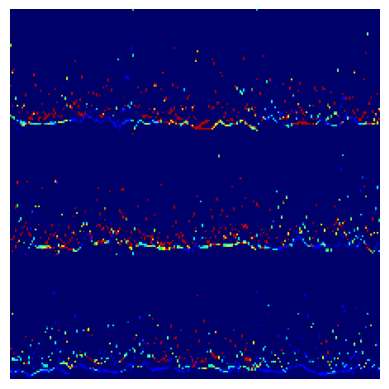

"\nloc = 1\nimage = data[loc].T\nplt.imshow(image, origin='lower')\nplt.axis('off')\nplt.show()\n"

In [4]:
cmap = mpl.colormaps['jet']
#cmap.set_under('darkblue')
cmap.set_over('brown')

#electrodes = [10, 42, 74, 106]
#electrodes = [11]
#for i in range (8):
    #electrodes += [electrodes[i] + 14]

def getImages (emg, electrodes):
    allImages = []
    for i in range (len(emg)):
    #for i in range (5):
        images = []

        #for j in range (4):
        for j in range (9):
            #signal = emg[i][j].numpy()
            signal = emg[i][electrodes[j]].numpy()
            time = np.linspace(start=0.001, stop=0.25, num=len(signal))
            imfs = EMD().emd(signal, time)

            instantaneous_frequencies = []
            instantaneous_amplitudes = []
            num_imfs = min(3, len(imfs))

            for x in range(num_imfs):
                imf = imfs[x]
                analytic_signal = hilbert(imf)
                #instantaneous_frequency = np.abs(np.gradient(np.arctan2(np.imag(analytic_signal), np.real(analytic_signal)))) * 500.0 / np.pi
                
                '''
                frequencies = []
                pz = 0
                pzold = pz
                for y in range (len(analytic_signal)):
                    pz = np.arctan2(np.imag(analytic_signal), np.real(analytic_signal))
                    f = -(pz - pzold)
                    if ()
                '''
                instantaneous_frequency = (np.gradient(np.arctan2(np.imag(analytic_signal), np.real(analytic_signal))))
                for y in range (len(instantaneous_frequency)):
                    if instantaneous_frequency[y] < -np.pi:
                        instantaneous_frequency[y] += 2.0*np.pi
                    #elif instantaneous_frequency[y] < 0:
                        #instantaneous_frequency[y] = np.pi + instantaneous_frequency[y]
                        #print("problem")
                #instantaneous_frequency = np.unwrap(instantaneous_frequency)
                instantaneous_frequency = instantaneous_frequency * 500.0 / np.pi

                instantaneous_amplitude = 200.0*np.log10(np.sqrt(np.real(analytic_signal) ** 2 + np.imag(analytic_signal) ** 2) + 1.0)
                instantaneous_frequencies.append(instantaneous_frequency)
                instantaneous_amplitudes.append(instantaneous_amplitude)

            #frequency_bins = np.linspace(0, 500, num=len(signal), endpoint=False)
            frequency_bins = np.linspace(0, 500, num=len(signal), endpoint=False)
            frequency_bin_indices = np.zeros((num_imfs, len(signal)))
            for x in range (num_imfs):
                frequency_bin_indices[x] = np.argmin(np.abs(frequency_bins[:, np.newaxis] - 
                                                        instantaneous_frequencies[x]), axis=0)

            time_bins = len(signal)
            
            images += [np.zeros((3, time_bins, frequency_bins.size))]
            #images += [np.full((3, time_bins, frequency_bins.size), -1)]
            for p in range(time_bins):
                for q in range(frequency_bins.size):
                    images[j][:, p, q] = [0.0, 0.0, 0.5]
            '''
            color = cmap(0)[:3]
            for p in range(time_bins):
                for q in range(frequency_bins.size):
                    images[j][:, p, q] = color

            for t in range(time_bins):
                for s in range(num_imfs):
                    amplitude_normalized = (instantaneous_amplitudes[s][t] - np.min(instantaneous_amplitudes)) / \
                                           (np.max(instantaneous_amplitudes) - np.min(instantaneous_amplitudes))
                    images[j][:, t, int(frequency_bin_indices[s][t])] = cmap(amplitude_normalized)[:3]
            '''
            #instantaneous_amplitudes = np.array(instantaneous_amplitudes) + 1
            #amplitude_log = np.log(instantaneous_amplitudes)
            #amplitude_log = instantaneous_amplitudes
            for t in range(time_bins):
                for s in reversed(range(num_imfs)):
                    if (frequency_bin_indices[s][t] > 0):
                        #amplitude_normalized = (amplitude_log[s][t] - np.min(amplitude_log)) / \
                                            #(np.max(amplitude_log) - np.min(amplitude_log))
                        #amplitude_normalized = amplitude_log[s][t]
                        scaleFactor = 5.0 / np.pi
                        color = cmap(instantaneous_amplitudes[s][t])
                        color_2 = cmap(instantaneous_amplitudes[s][t] / scaleFactor)
                        color_3 = cmap(instantaneous_amplitudes[s][t] / (scaleFactor * scaleFactor))
                        #color_4 = cmap(instantaneous_amplitudes[s][t] / (scaleFactor * scaleFactor * scaleFactor))
                        
                        # Setting pixel colors
                        images[j][:, t, int(frequency_bin_indices[s][t])] = color[:3]
                        # 1 away
                        images[j][:, t, int(frequency_bin_indices[s][t]) - 1] = color_2[:3]
                        if (int(frequency_bin_indices[s][t]) < frequency_bins.size - 1):
                            images[j][:, t, int(frequency_bin_indices[s][t]) + 1] = color_2[:3]
                        # 2 away
                        if (int(frequency_bin_indices[s][t]) > 1):
                            images[j][:, t, int(frequency_bin_indices[s][t]) - 2] = color_3[:3]
                        if (int(frequency_bin_indices[s][t]) < frequency_bins.size - 2):
                            images[j][:, t, int(frequency_bin_indices[s][t]) + 2] = color_3[:3]
                        # 3 away
                        #if (int(frequency_bin_indices[s][t]) > 2):
                            #images[j][:, t, int(frequency_bin_indices[s][t]) - 3] = color_4[:3]
                        #if (int(frequency_bin_indices[s][t]) < frequency_bins.size - 3):
                            #images[j][:, t, int(frequency_bin_indices[s][t]) + 3] = color_4[:3]
                        
                
        # combine images (for 2x2 fused images)
        #for j in range (len(images)):
            #images[j] = transforms.Resize(112, interpolation=transforms.InterpolationMode.NEAREST_EXACT, antialias=True)(torch.from_numpy(images[j]))

        '''    
        row1 = np.concatenate((images[0], images[1]), axis=2)
        row2 = np.concatenate((images[2], images[3]), axis=2)
        image = np.concatenate((row1, row2), axis=1)
        '''
        row1 = np.concatenate((images[0], images[1], images[2]), axis=2)
        row2 = np.concatenate((images[3], images[4], images[5]), axis=2)
        row3 = np.concatenate((images[6], images[7], images[8]), axis=2)
        image = np.concatenate((row1, row2, row3), axis=1)
        
        image = transforms.Resize(224, interpolation=transforms.InterpolationMode.NEAREST_EXACT, antialias=False)(torch.from_numpy(image))
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        '''
        preprocess = transforms.Compose([transforms.Resize(224, antialias=False), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        #image_resized = transforms.Resize(224)(torch.from_numpy(image))
        #image_normalized = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_resized)
        image_normalized = ResNet50_Weights.DEFAULT.transforms(antialias=False)(torch.from_numpy(image))
        #image_normalized = preprocess(torch.from_numpy(image))
        '''
        #allImages.append(image_normalized.numpy().astype(np.float32))
        allImages.append(image.numpy().astype(np.float32))

        if i % 100 == 0:
            print("progress: " + str(i) + "/" + str(len(emg)))
            print(labels[0][i])
            plt.imshow(allImages[i].T, origin='lower')
            plt.axis('off')
            plt.show()
    
    return allImages

#for a in range (10):
a = 0
file_path = "./CapgMyo_B/modSpect_" + str(a+1) + ".npy"
data = getImages(emg[a], maxChannels[a])
np.save(file_path, data)
#file_path = "./CapgMyo_B/test_labels_" + str(a+1) + ".npy"
#np.save(file_path, labels[a])

'''
loc = 1
image = data[loc].T
plt.imshow(image, origin='lower')
plt.axis('off')
plt.show()
'''

In [7]:
# split into training, validation, and test set
leaveOut = False
'''
label_1 = np.load("./CapgMyo_B/Labels_1.npy", allow_pickle=True)
emg_1 = np.load("./CapgMyo_B/Spectrograms_1.npy", allow_pickle=True)
label_2 = np.load("./CapgMyo_B/Labels_2.npy", allow_pickle=True)
emg_2 = np.load("./CapgMyo_B/Spectrograms_2.npy", allow_pickle=True)
label_3 = np.load("./CapgMyo_B/Labels_3.npy", allow_pickle=True)
emg_3 = np.load("./CapgMyo_B/Spectrograms_3.npy", allow_pickle=True)
label_4 = np.load("./CapgMyo_B/Labels_4.npy", allow_pickle=True)
emg_4 = np.load("./CapgMyo_B/Spectrograms_4.npy", allow_pickle=True)
label_5 = np.load("./CapgMyo_B/Labels_5.npy", allow_pickle=True)
emg_5 = np.load("./CapgMyo_B/Spectrograms_5.npy", allow_pickle=True)
label_6 = np.load("./CapgMyo_B/Labels_6.npy", allow_pickle=True)
emg_6 = np.load("./CapgMyo_B/Spectrograms_6.npy", allow_pickle=True)
label_7 = np.load("./CapgMyo_B/Labels_7.npy", allow_pickle=True)
emg_7 = np.load("./CapgMyo_B/Spectrograms_7.npy", allow_pickle=True)
label_8 = np.load("./CapgMyo_B/Labels_8.npy", allow_pickle=True)
emg_8 = np.load("./CapgMyo_B/Spectrograms_8.npy", allow_pickle=True)
label_9 = np.load("./CapgMyo_B/Labels_9.npy", allow_pickle=True)
emg_9 = np.load("./CapgMyo_B/Spectrograms_9.npy", allow_pickle=True)
label_10 = np.load("./CapgMyo_B/Labels_10.npy", allow_pickle=True)
emg_10 = np.load("./CapgMyo_B/Spectrograms_10.npy", allow_pickle=True)


data = np.concatenate((emg_1, emg_2, emg_3, emg_4, emg_5, emg_6, emg_7, emg_8, emg_9, emg_10), axis=0).astype(np.float32)
combined_labels = np.concatenate((label_1, label_2, label_3, label_4, label_5, label_6, label_7, label_8, label_9, label_10), axis=0).astype(np.float32)
'''
data = np.load("./CapgMyo_B/modSpect_1.npy", allow_pickle=True).astype(np.float32)
combined_labels = np.load("./CapgMyo_B/Labels_1.npy", allow_pickle=True).astype(np.float32)
print(data.shape)
print(combined_labels.shape)

(2560, 3, 224, 224)
(2560, 8)


In [8]:
'''
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(data, combined_labels, test_size=0.2)
if leaveOut:
    test = torch.from_numpy(outImages).to(torch.float32)
else:
    X_validation, X_test, Y_validation, Y_test = model_selection.train_test_split(X_validation, Y_validation, test_size=0.5)

X_train = torch.from_numpy(X_train).to(torch.float32)
Y_train = torch.from_numpy(Y_train).to(torch.float32)
X_validation = torch.from_numpy(X_validation).to(torch.float32)
Y_validation = torch.from_numpy(Y_validation).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(Y_test).to(torch.float32)
print(X_train.size())
print(X_validation.size())
print(X_test.size())
'''
X_train = data[:1280]
Y_train = combined_labels[:1280]
X_validation, X_test, Y_validation, Y_test = model_selection.train_test_split(data[1280:], combined_labels[1280:], test_size=0.8)
X_validation = torch.from_numpy(X_validation).to(torch.float32)
Y_validation = torch.from_numpy(Y_validation).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(Y_test).to(torch.float32)

In [11]:
print(len(X_train))

1280


In [14]:
class Data(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

batch_size = 2
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_validation, Y_validation)), batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size)

In [16]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-2])
#model = nn.Sequential(*list(model.children())[:-4])
num_features = model[-1][-1].conv3.out_channels
#num_features = model.fc.in_features
dropout = 0.5
model.add_module('avgpool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(num_features, 1024))
model.add_module('relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(dropout))
model.add_module('fc2', nn.Linear(1024, 1024))
model.add_module('relu2', nn.ReLU())
model.add_module('dropout2', nn.Dropout(dropout))
model.add_module('fc3', nn.Linear(1024, 8))
model.add_module('softmax', nn.Softmax(dim=1))

num = 0
for name, param in model.named_parameters():
    num += 1
    if (num > 33): # for layers 2, 3, 4 trainable
        param.requires_grad = True
    else:
        param.requires_grad = False

layers = [(name, param.requires_grad) for name, param in model.named_parameters()]
for i in range(len(layers)):
    print(layers[i])

('0.weight', False)
('1.weight', False)
('1.bias', False)
('4.0.conv1.weight', False)
('4.0.bn1.weight', False)
('4.0.bn1.bias', False)
('4.0.conv2.weight', False)
('4.0.bn2.weight', False)
('4.0.bn2.bias', False)
('4.0.conv3.weight', False)
('4.0.bn3.weight', False)
('4.0.bn3.bias', False)
('4.0.downsample.0.weight', False)
('4.0.downsample.1.weight', False)
('4.0.downsample.1.bias', False)
('4.1.conv1.weight', False)
('4.1.bn1.weight', False)
('4.1.bn1.bias', False)
('4.1.conv2.weight', False)
('4.1.bn2.weight', False)
('4.1.bn2.bias', False)
('4.1.conv3.weight', False)
('4.1.bn3.weight', False)
('4.1.bn3.bias', False)
('4.2.conv1.weight', False)
('4.2.bn1.weight', False)
('4.2.bn1.bias', False)
('4.2.conv2.weight', False)
('4.2.bn2.weight', False)
('4.2.bn2.bias', False)
('4.2.conv3.weight', False)
('4.2.bn3.weight', False)
('4.2.bn3.bias', False)
('5.0.conv1.weight', True)
('5.0.bn1.weight', True)
('5.0.bn1.bias', True)
('5.0.conv2.weight', True)
('5.0.bn2.weight', True)
('5.0.bn2.

In [17]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#learn = 0.0003
learn = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learn)

cuda
Epoch 1/20 | Train Loss: 2.0668 | Val Loss: 2.0377
Train Accuracy: 0.1450 | Val Accuracy: 0.1914
Epoch 2/20 | Train Loss: 1.9254 | Val Loss: 1.8083
Train Accuracy: 0.3164 | Val Accuracy: 0.4609
Epoch 3/20 | Train Loss: 1.7901 | Val Loss: 1.7783
Train Accuracy: 0.4814 | Val Accuracy: 0.4961
Epoch 4/20 | Train Loss: 1.7017 | Val Loss: 1.7113
Train Accuracy: 0.5708 | Val Accuracy: 0.5586
Epoch 5/20 | Train Loss: 1.6568 | Val Loss: 1.7343
Train Accuracy: 0.6138 | Val Accuracy: 0.5352
Epoch 6/20 | Train Loss: 1.6036 | Val Loss: 1.6374
Train Accuracy: 0.6680 | Val Accuracy: 0.6406
Epoch 7/20 | Train Loss: 1.5585 | Val Loss: 1.6489
Train Accuracy: 0.7192 | Val Accuracy: 0.6211
Epoch 8/20 | Train Loss: 1.5133 | Val Loss: 1.6583
Train Accuracy: 0.7617 | Val Accuracy: 0.6055
Epoch 9/20 | Train Loss: 1.4832 | Val Loss: 1.5841
Train Accuracy: 0.7910 | Val Accuracy: 0.6875
Epoch 10/20 | Train Loss: 1.4322 | Val Loss: 1.6286
Train Accuracy: 0.8472 | Val Accuracy: 0.6445
Epoch 11/20 | Train Loss

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Acc,▁▃▄▅▅▆▆▆▇▇▇▇████████
Train Loss,█▇▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
Valid Acc,▁▄▅▅▅▆▆▆▇▆▆▇▆▇▇▇▇███
Valid Loss,█▅▅▄▄▃▃▃▂▃▃▂▃▂▂▂▂▁▁▁
Epoch,19
Train Acc,0.93457
Train Loss,1.34141
Valid Acc,0.75
Valid Loss,1.53216


Test Loss: 1.5367 | Test Accuracy: 0.7422


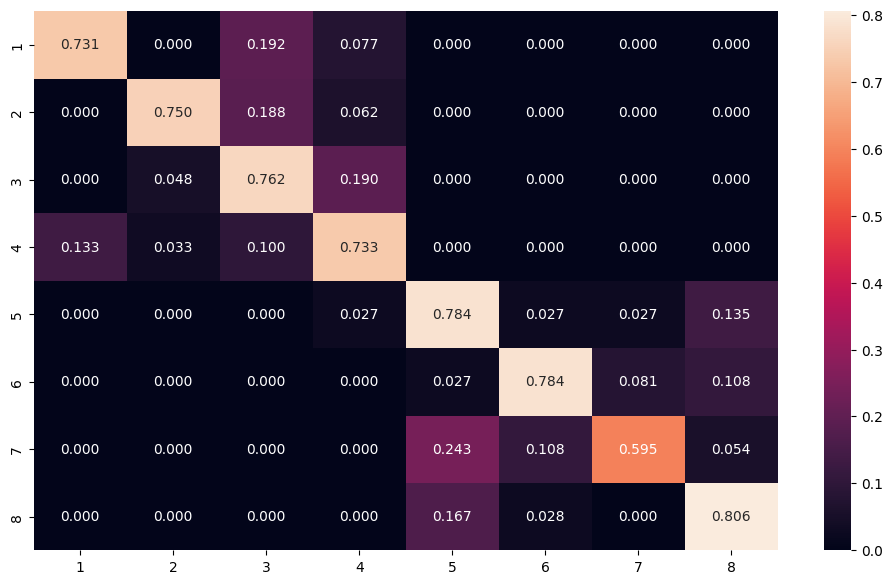

In [18]:
# Training loop
import gc
gc.collect()
torch.cuda.empty_cache()

run = wandb.init(name='CNN', project='emg_benchmarking', entity='msoh')
wandb.config.lr = learn

num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

wandb.watch(model)

for epoch in range(num_epochs):
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        train_loss += loss.item()

        train_acc += np.mean(np.argmax(output.cpu().detach().numpy(), 
                                       axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        loss.backward()
        optimizer.step()
        #X_batch = X_batch.to('cpu')
        #Y_batch = Y_batch.to('cpu')

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            output = model(X_batch)
            val_loss += criterion(output, Y_batch).item()

            val_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))
            #X_batch = X_batch.to('cpu')
            #Y_batch = Y_batch.to('cpu')

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")

    wandb.log({
        "Epoch": epoch,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
    
run.finish()

# %%
# Testing
pred = []
true = []

model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        output = model(X_batch)
        test_loss += criterion(output, Y_batch).item()

        test_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        output = np.argmax(output.cpu().detach().numpy(), axis=1)
        pred.extend(output)
        labels = np.argmax(Y_batch.cpu().detach().numpy(), axis=1)
        true.extend(labels)
        #X_batch = X_batch.to('cpu')
        #Y_batch = Y_batch.to('cpu')

test_loss /= len(test_loader)
test_acc /= len(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = np.arange(1, 9, 1),
                     columns = np.arange(1, 9, 1))
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt=".3f")
plt.savefig('output.png')